# BLonD simulation script to generate PyORBIT input longitudinal distribution

##  Notes
- Python 3.0 unlike PyORBIT which runs in a virtual python 2.7 environment
- This particular script will take a PyORBIT simulation parameter file as input if required
- The generated distribution will not be `space charge matched` longitudinally, this requires an iterative simulation to match properly as is shown below

In [1]:
# General imports
#%matplotlib notebook
import sys
import numpy as np
from math import log10, floor

import scipy.io as sio
from scipy.io import savemat
from scipy.constants import c
from scipy.optimize import curve_fit
from scipy.stats import moment, kurtosis

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec

# BLonD imports
sys.path.append('./BLonD')
from blond.beam.beam import Proton, Beam
from blond.input_parameters.ring import Ring
from blond.input_parameters.rf_parameters import RFStation
from blond.trackers.tracker import RingAndRFTracker, FullRingAndRF
from blond.beam.distributions import matched_from_line_density

In [2]:
def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [3]:
def gaussian(x, A, mu, sig):
    """gaussian_3_parameter(x, A, mu, sig)"""
    return A*np.exp(-(x-mu)**2/(2*sig**2))

In [4]:
def LorentzGamma(E_tot, E_rest=938.27208816E6):
    return (E_tot / E_rest)
    
def LorentzGamma_from_beta(beta):
    return (1./np.sqrt(1.-beta**2))    

def LorentzBeta(gamma):
    return np.sqrt( 1. - (1./gamma**2) )

def RelativisticMomentum(gamma, E_rest=938.27208816E6):
    return (gamma * E_rest * LorentzBeta(gamma))

def z_to_time(z, beta): 
    c = 299792458
    return z / (c * beta)
    
def E_from_gamma(gamma, E_rest=938.27208816E6):
    return (gamma*E_rest)

def dpp_from_dE(dE, E, beta):
    return (dE / (E * beta**2))
    
def dE_from_dpp(dpp, E, beta):
    return (dpp * E * beta**2)

In [5]:
# Read from simulation parameters file
from simulation_parameters import parameters as p

In [6]:
p

{'intensity': 7000000000000.0,
 'epsn_x': 1.2e-05,
 'epsn_y': 8e-06,
 'bunch_length': 2.2e-07,
 'blength': 2.2e-07,
 'eps_z': 2.6,
 'rf_voltage': 40.0,
 'BLonD_file': '../../06_Dispersion_Mismatch/BLonD_Files_SC/BLonD_Longitudinal_Distn.npz',
 'tunex': '619',
 'tuney': '624',
 'lattice_start': 'BWSH65',
 'n_macroparticles': 500000,
 'gamma': 2.49038064,
 'beta': 0.9158392756488949,
 'LongitudinalJohoParameter': 1.2,
 'LongitudinalCut': 2.4,
 'TransverseCut': 5,
 'circumference': 628.3185307179587,
 'phi_s': 0,
 'macrosize': 14000000.0,
 'sig_z': 15.100893916884697,
 'turns_max': 2200,
 'turns_print': [-1,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  60,
  70,
  80,
  90,
  199,
  399,
  599,
  799,
  999,
  1199,
  1399,
  1599,
  1799,
  199

In [7]:
# PS Pre-LIU 1.4 GeV Injection
LIU = False

if LIU:
    print('PS LIU 2 GeV Injection')
    Lorentz_Gamma = 3.1316
    
else:
    print( 'PS Pre-LIU 1.4 GeV Injection')
    Lorentz_Gamma = 2.4921
        
print ('----------------------')
print( 'Lorentz Gamma =\t', Lorentz_Gamma)
Lorentz_Beta = LorentzBeta(Lorentz_Gamma)
print ('Lorentz Beta =\t', round_sig(Lorentz_Beta))
Beam_Energy = E_from_gamma(Lorentz_Gamma)
print ('Energy =\t', round_sig(Beam_Energy/1E9), 'GeV')
Beam_Momentum = RelativisticMomentum(938.27208816E6, Lorentz_Gamma)
print ('Momentum =\t', round_sig(Beam_Momentum)/1E9, 'GeV/c')

PS Pre-LIU 1.4 GeV Injection
----------------------
Lorentz Gamma =	 2.4921
Lorentz Beta =	 0.916
Energy =	 2.34 GeV
Momentum =	 2.34 GeV/c


In [33]:
save_folder = 'Plots/'
output_bins = 200

# Case selection
n_macroparticles = 5E5

# PS ring parameters
circumference = 2*np.pi*100.
bending_radius = 70.07887
kinetic_energy = 1.4e9

#gamma_t = 6.08378627 #2 GeV
gamma_t = 6.083785664 #1.4 GeV

bunch_intensity = p['intensity']

# PS bunch parameters Standard
particle_type = Proton()
full_bunch_length = 220e-9
rf_harmonic = 8
# full_emittance = 1.2
line_density_type='parabolic_line'

rf_voltage =83E3

beam_label = 'TOF_83kV'

In [34]:
 # Constructing BLonD objects

# Ring object
ring = Ring(circumference, 1/gamma_t**2.,
            kinetic_energy, particle_type,
            synchronous_data_type='kinetic energy')

# RF object
rf_station = RFStation(ring, rf_harmonic,
                       rf_voltage, np.pi)

# Beam object
beam = Beam(ring, n_macroparticles, bunch_intensity)

# Tracker objects
total_induced = None

longitudinal_tracker = RingAndRFTracker(rf_station, beam,
                                        TotalInducedVoltage=total_induced)

full_tracker = FullRingAndRF([longitudinal_tracker])

# Bunch generation
output_profile = matched_from_line_density(
    beam, full_tracker,
    TotalInducedVoltage=total_induced,
    bunch_length=full_bunch_length,
    line_density_type=line_density_type)[1]

# Using blond_common to verify separatrix and emittance

from blond_common.rf_functions.potential import (
    rf_potential_generation, find_potential_wells_cubic,
    potential_well_cut_cubic, trajectory_area_cubic)

n_points = 1000
t_rev = ring.t_rev[0]
eta_0 = ring.eta_0[0,0]
tot_energy = ring.energy[0,0]
beta_rel = ring.beta[0,0]
charge = ring.Particle.charge
energy_increment = ring.delta_E[0]
voltage = rf_station.voltage[0,0]
harmonic = rf_station.harmonic[0,0]
phi_rf = rf_station.phi_rf[0,0]


# Separatrix trajectory
time_bounds_sep = [output_profile[0][0],
                   output_profile[0][-1]]

time_array, rf_potential_array = rf_potential_generation(
    n_points, t_rev, voltage, harmonic, phi_rf, eta_0, charge, energy_increment,
    time_bounds=time_bounds_sep)

potwell_max_locs = find_potential_wells_cubic(
    time_array, rf_potential_array)[0]

time_array_list, potential_well_list = potential_well_cut_cubic(
    time_array, rf_potential_array, potwell_max_locs)

(time_sep, dEsep, hamiltonian, calc_area_sep,
 half_energy_height, full_length_time) = trajectory_area_cubic(
    time_array_list[0], potential_well_list[0],
    eta_0, beta_rel, tot_energy)


# Outter bunch trajectory
time_bounds_bunch = [np.min(output_profile[0][output_profile[1]!=0.]),
                     np.max(output_profile[0][output_profile[1]!=0.])]

time_array, rf_potential_array = rf_potential_generation(
    n_points, t_rev, voltage, harmonic, phi_rf, eta_0, charge, energy_increment,
    time_bounds=time_bounds_bunch)

potwell_max_locs = find_potential_wells_cubic(
    time_array, rf_potential_array)[0]

(time_bunch, dEbunch, hamiltonian, calc_area_bunch,
 half_energy_height, full_length_time) = trajectory_area_cubic(
    time_array, rf_potential_array,
    eta_0, beta_rel, tot_energy)


/home/HR/Documents/PS_TOF/01_Generate_Longitudinal_Distribution/blond_common/rf_functions/potential.py:451: RuntimeWarning: invalid value encountered in sqrt
  dEtraj = np.sqrt((potential_array[0]-potential_array) / eom_factor_dE)



	  dt - dE :  dt  limit set to  120.89000000000001

	  dt - dE :  dE  limit set to  10.109

	  dt - $\frac{\delta p}{p_0}$ :  dt  limit set to  120.89000000000001

	  dt - $\frac{\delta p}{p_0}$ :  $\frac{\delta p}{p_0}$  limit set to  5.159000000000001


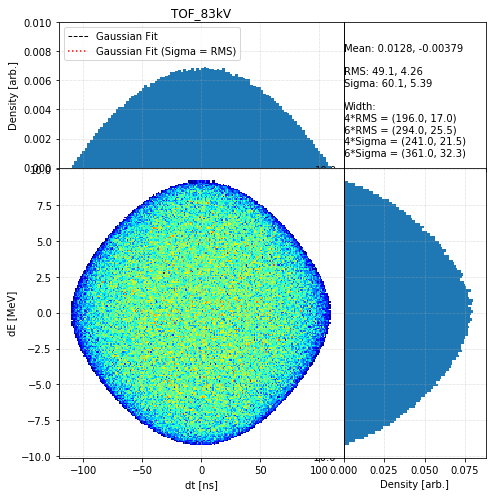

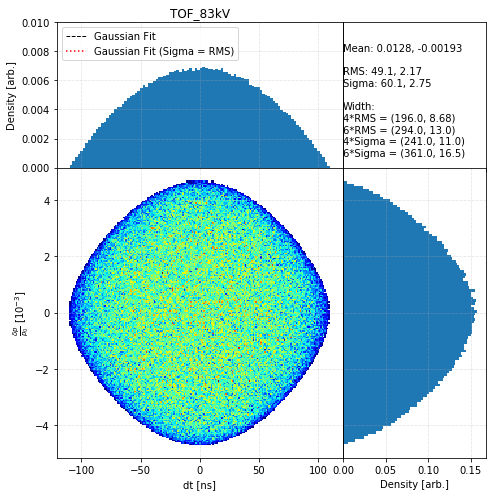

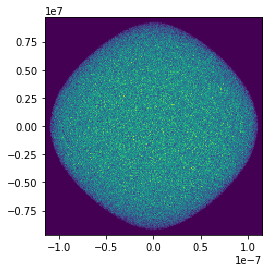

In [35]:
# PLOTS
# Overly complicated due to copying from elsewhere

savename = str(save_folder + beam_label +'_z_dE_hist.png' )

master_bins = output_bins

x_dat_lim = 1.
y_dat_lim = 1.
max_x_hist = 0.01
max_y_hist = 0.01

x_lab = 'dt'
y_lab = 'dE'
x_unit = 'ns'
y_unit = 'MeV'

y_dat = np.array(beam.dE)/1E6
x_dat = np.array((beam.dt - rf_station.t_rf[0,0]/2.))*1E9

my_cmap = plt.cm.jet
my_cmap.set_under('w',1)
title = str( beam_label )    

fig = plt.figure(figsize=(7,7))
gs = gridspec.GridSpec(nrows=3,ncols=3,figure=fig,width_ratios= [1, 1, 1],height_ratios=[1, 1, 1],wspace=0.0,hspace=0.0)

# Calculate RMS Qx and Qy
#-------------------------------------------------------------------
x_dat_rms = np.sqrt(moment(x_dat,2))
y_dat_rms = np.sqrt(moment(y_dat,2))
x_dat_min = np.min(x_dat)
x_dat_max = np.max(x_dat)
y_dat_min = np.min(y_dat)
y_dat_max = np.max(y_dat) 
x_dat_4sig = 4 * x_dat_rms
y_dat_4sig = 4 * y_dat_rms
x_dat_6sig = 6 * x_dat_rms
y_dat_6sig = 6 * y_dat_rms

x_fine = np.arange(x_dat_min, x_dat_max, 1E5)
y_fine = np.arange(y_dat_min, y_dat_max, 1E5)

# TEXT BOX (top right)
#-------------------------------------------------------------------
ax4 = fig.add_subplot(gs[0, 2:3])
ax4.set_yticklabels([])
ax4.set_xticklabels([])

# FIRST SUBPLOT - x histogram
#-------------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0:2])
ax1.set_title(title)    
n_x, bins_x, patches_x = ax1.hist(x_dat, bins=int(master_bins/2), range=(np.min(x_dat), np.max(x_dat)), density=True)
bins_x = bins_x[:-1] + (bins_x[1]-bins_x[0])/2 # centre bins

x_dat_max = np.max(x_dat)
x_dat_min = np.min(x_dat)       

y_dat_max = np.max(y_dat)
y_dat_min = np.min(y_dat)           

if (-1*x_dat_min) > (x_dat_max):
    x_dat_lim = round(-1*x_dat_min, 2) * 1.1
else:
    x_dat_lim = round(x_dat_max, 2) * 1.1     

if (-1*y_dat_min) > (y_dat_max):
    y_dat_lim = round(-1*y_dat_min, 2) * 1.1
else:
    y_dat_lim = round(y_dat_max, 2) * 1.1        
print( '\n\t ',x_lab,'-',y_lab,': ',x_lab,' limit set to ', x_dat_lim)
print( '\n\t ',x_lab,'-',y_lab,': ',y_lab,' limit set to ', y_dat_lim)

if np.max(n_x) > max_x_hist :
    max_x_hist = round(np.max(n_x),2) * 1.1
    print( '\n\t ',x_lab,'-',y_lab,': max_x_hist set to ', max_x_hist)

# fit Gaussian to histogram
try:    
    amp_min_x = 0.99 * np.max(n_x)
    amp_max_x = 1.2 * np.max(n_x)
    if np.mean(x_dat) < 0:
        mean_min_x = 1.05 * np.mean(x_dat)
        mean_max_x = 0.95 * np.mean(x_dat)
    else:    
        mean_min_x = 0.95 * np.mean(x_dat)
        mean_max_x = 1.05 * np.mean(x_dat)                
    sig_min_x = 0.5 * x_dat_rms
    sig_max_x = 1.5 * x_dat_rms
    poptx, pcov = curve_fit(gaussian, bins_x, n_x, method = 'trf', bounds =((amp_min_x, mean_min_x, sig_min_x), (amp_max_x, mean_max_x, sig_max_x)))
    ax1.plot(x_fine, gaussian(x_fine, poptx[0], poptx[1], poptx[2]), 'k--', lw=1, label='Gaussian Fit')
    ax1.plot(x_fine, gaussian(x_fine, poptx[0], poptx[1], x_dat_rms), 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')
    ax1.legend(loc=2)
except RuntimeError:
    print ('\n\t TUNE: RuntimeError ', beam_label, ' scan tune =', tune_tit, ' turn = ', turn, ' ', x_dat, ' Gaussian fit not found')

# ~ ax1.set_ylabel('Frequency')
ax1.set_ylabel('Density [arb.]')    
ax1.grid(which='both', ls=':', lw=0.5)
ax1.set_ylim(0, max_x_hist)
ax1.set_xlim(-1*x_dat_lim, x_dat_lim)

# SECOND SUBPLOT - y histogram
#-------------------------------------------------------------------
ax3 = fig.add_subplot(gs[1:3, 2])
n_y, bins_y, patches_y = ax3.hist(y_dat, bins=int(master_bins/2), range=(np.min(y_dat), np.max(y_dat)), orientation=u'horizontal', density=True)
bins_y = bins_y[:-1] + (bins_y[1]-bins_y[0])/2 # centre bins

#if first_turn_again:
#if np.max(n_y) > max_y_hist :
max_y_hist = round(np.max(n_y),2) * 1.1
#    print( '\n\t ',x_lab,'-',y_lab,': max_y_hist set to ', max_y_hist)
 #   first_turn_again = False

# fit Gaussian to histogram
try:
    amp_min_y = 0.99 * np.max(n_y)
    amp_max_y = 1.2 * np.max(n_y)
    if np.mean(y_dat) < 0:
        mean_min_y = 1.05 * np.mean(y_dat)
        mean_max_y = 0.95 * np.mean(y_dat)
    else:    
        mean_min_y = 0.95 * np.mean(y_dat)
        mean_max_y = 1.05 * np.mean(y_dat)  
    sig_min_y = 0.5 * y_dat_rms
    sig_max_y = 1.5 * y_dat_rms
    popty, pcovy = curve_fit(gaussian, bins_y, n_y, method = 'trf', bounds =((amp_min_y, mean_min_y, sig_min_y), (amp_max_y, mean_max_y, sig_max_y)))
    ax3.plot(gaussian(y_fine, popty[0], popty[1], popty[2]), y_fine, 'k--', lw=1, label='Gaussian Fit')
    ax3.plot(gaussian(y_fine, popty[0], popty[1], y_dat_rms), y_fine, 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')    
except RuntimeError:
    print( '\n\t TUNE: RuntimeError ', beam_label,' Gaussian fit not found')

ax3.set_xlabel('Density [arb.]')    
ax3.set_xlim(0, max_y_hist)
ax3.set_ylim(-1*y_dat_lim, y_dat_lim)
ax3.grid(which='both', ls=':', lw=0.5)

# MAIN PLOT: TUNE FOOTPRINT
#-------------------------------------------------------------------
ax2 = fig.add_subplot(gs[1:3, 0:2])
ax2.hist2d(x_dat, y_dat, bins=master_bins, cmap=my_cmap, vmin=1, range=[[np.min(x_dat), np.max(x_dat)], [np.min(y_dat), np.max(y_dat)]]) 
ax2.set_xlabel(str(x_lab+' ['+ x_unit +']'))
ax2.set_ylabel(str(y_lab+' ['+ y_unit +']'))
ax2.set_xlim(-1*x_dat_lim, x_dat_lim)
ax2.set_ylim(-1*y_dat_lim, y_dat_lim)
ax2.grid(which='both', ls=':', lw=0.5)

ax4txt = str(
    'Mean: ' + str(round_sig(np.mean(x_dat),3)) + ', ' + str(round_sig(np.mean(y_dat),3)) + '\n' + '\n' +
    'RMS: ' + str(round_sig(x_dat_rms,3)) + ', ' + str(round_sig(y_dat_rms,3)) + '\n' +
    'Sigma: ' + str(round_sig(poptx[2],3)) + ', ' + str(round_sig(popty[2],3)) + '\n' + '\n' +
    'Width:\n' +
    '4*RMS = (' + str(round_sig(x_dat_4sig,3)) + ', ' + str(round_sig(y_dat_4sig,3)) + ')\n' +
    '6*RMS = (' + str(round_sig(x_dat_6sig,3)) + ', ' + str(round_sig(y_dat_6sig,3)) + ')\n' +
    '4*Sigma = (' + str(round_sig(4*poptx[2],3)) + ', ' + str(round_sig(4*popty[2],3)) + ')\n' +
    '6*Sigma = (' + str(round_sig(6*poptx[2],3)) + ', ' + str(round_sig(6*popty[2],3)) + ')\n' 
    )
ax4.text(0.001, 0.001, ax4txt, fontsize=10)

plt.tight_layout()
fig.savefig(savename)


savename = str(save_folder + beam_label +'_dt_dpp_hist.png' )

master_bins = int(200)

x_dat_lim = 1.
y_dat_lim = 1.
max_x_hist = 0.01
max_y_hist = 0.01

x_lab = 'dt'
y_lab = r'$\frac{\delta p}{p_0}$'
x_unit = 'ns'
y_unit = r'$10^{-3}$'

y_dat = dpp_from_dE(np.array(beam.dE), Beam_Energy, Lorentz_Beta)*1E3
x_dat = np.array((beam.dt - rf_station.t_rf[0,0]/2.))*1E9

my_cmap = plt.cm.jet
my_cmap.set_under('w',1)
beam_label
title = str( beam_label )    

fig = plt.figure(figsize=(7,7))
gs = gridspec.GridSpec(nrows=3,ncols=3,figure=fig,width_ratios= [1, 1, 1],height_ratios=[1, 1, 1],wspace=0.0,hspace=0.0)

# Calculate RMS Qx and Qy
#-------------------------------------------------------------------
x_dat_rms = np.sqrt(moment(x_dat,2))
y_dat_rms = np.sqrt(moment(y_dat,2))
x_dat_min = np.min(x_dat)
x_dat_max = np.max(x_dat)
y_dat_min = np.min(y_dat)
y_dat_max = np.max(y_dat) 
x_dat_4sig = 4 * x_dat_rms
y_dat_4sig = 4 * y_dat_rms
x_dat_6sig = 6 * x_dat_rms
y_dat_6sig = 6 * y_dat_rms

x_fine = np.arange(x_dat_min, x_dat_max, 1E5)
y_fine = np.arange(y_dat_min, y_dat_max, 1E5)

# TEXT BOX (top right)
#-------------------------------------------------------------------
ax4 = fig.add_subplot(gs[0, 2:3])
ax4.set_yticklabels([])
ax4.set_xticklabels([])

# FIRST SUBPLOT - x histogram
#-------------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0:2])
ax1.set_title(title)    
n_x, bins_x, patches_x = ax1.hist(x_dat, bins=int(master_bins/2), range=(np.min(x_dat), np.max(x_dat)), density=True)
bins_x = bins_x[:-1] + (bins_x[1]-bins_x[0])/2 # centre bins

x_dat_max = np.max(x_dat)
x_dat_min = np.min(x_dat)       

y_dat_max = np.max(y_dat)
y_dat_min = np.min(y_dat)           

if (-1*x_dat_min) > (x_dat_max):
    x_dat_lim = round(-1*x_dat_min, 2) * 1.1
else:
    x_dat_lim = round(x_dat_max, 2) * 1.1     

if (-1*y_dat_min) > (y_dat_max):
    y_dat_lim = round(-1*y_dat_min, 2) * 1.1
else:
    y_dat_lim = round(y_dat_max, 2) * 1.1        
print( '\n\t ',x_lab,'-',y_lab,': ',x_lab,' limit set to ', x_dat_lim)
print( '\n\t ',x_lab,'-',y_lab,': ',y_lab,' limit set to ', y_dat_lim)

if np.max(n_x) > max_x_hist :
    max_x_hist = round(np.max(n_x),2) * 1.1
    print( '\n\t ',x_lab,'-',y_lab,': max_x_hist set to ', max_x_hist)

# fit Gaussian to histogram
try:    
    amp_min_x = 0.99 * np.max(n_x)
    amp_max_x = 1.2 * np.max(n_x)
    if np.mean(x_dat) < 0:
        mean_min_x = 1.05 * np.mean(x_dat)
        mean_max_x = 0.95 * np.mean(x_dat)
    else:    
        mean_min_x = 0.95 * np.mean(x_dat)
        mean_max_x = 1.05 * np.mean(x_dat)                
    sig_min_x = 0.5 * x_dat_rms
    sig_max_x = 1.5 * x_dat_rms
    poptx, pcov = curve_fit(gaussian, bins_x, n_x, method = 'trf', bounds =((amp_min_x, mean_min_x, sig_min_x), (amp_max_x, mean_max_x, sig_max_x)))
    ax1.plot(x_fine, gaussian(x_fine, poptx[0], poptx[1], poptx[2]), 'k--', lw=1, label='Gaussian Fit')
    ax1.plot(x_fine, gaussian(x_fine, poptx[0], poptx[1], x_dat_rms), 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')
    ax1.legend(loc=2)
except RuntimeError:
    print ('\n\t TUNE: RuntimeError ', beam_label, ' scan tune =', tune_tit, ' turn = ', turn, ' ', x_dat, ' Gaussian fit not found')

# ~ ax1.set_ylabel('Frequency')
ax1.set_ylabel('Density [arb.]')    
ax1.grid(which='both', ls=':', lw=0.5)
ax1.set_ylim(0, max_x_hist)
ax1.set_xlim(-1*x_dat_lim, x_dat_lim)

# SECOND SUBPLOT - y histogram
#-------------------------------------------------------------------
ax3 = fig.add_subplot(gs[1:3, 2])
n_y, bins_y, patches_y = ax3.hist(y_dat, bins=int(master_bins/2), range=(np.min(y_dat), np.max(y_dat)), orientation=u'horizontal', density=True)
bins_y = bins_y[:-1] + (bins_y[1]-bins_y[0])/2 # centre bins

#if first_turn_again:
#if np.max(n_y) > max_y_hist :
max_y_hist = round(np.max(n_y),2) * 1.05
#    print( '\n\t ',x_lab,'-',y_lab,': max_y_hist set to ', max_y_hist)
 #   first_turn_again = False

# fit Gaussian to histogram
try:
    amp_min_y = 0.99 * np.max(n_y)
    amp_max_y = 1.2 * np.max(n_y)
    if np.mean(y_dat) < 0:
        mean_min_y = 1.05 * np.mean(y_dat)
        mean_max_y = 0.95 * np.mean(y_dat)
    else:    
        mean_min_y = 0.95 * np.mean(y_dat)
        mean_max_y = 1.05 * np.mean(y_dat)  
    sig_min_y = 0.5 * y_dat_rms
    sig_max_y = 1.5 * y_dat_rms
    popty, pcovy = curve_fit(gaussian, bins_y, n_y, method = 'trf', bounds =((amp_min_y, mean_min_y, sig_min_y), (amp_max_y, mean_max_y, sig_max_y)))
    ax3.plot(gaussian(y_fine, popty[0], popty[1], popty[2]), y_fine, 'k--', lw=1, label='Gaussian Fit')
    ax3.plot(gaussian(y_fine, popty[0], popty[1], y_dat_rms), y_fine, 'r:', lw=1.5, label='Gaussian Fit (Sigma = RMS)')    
except RuntimeError:
    print( '\n\t TUNE: RuntimeError ', beam_label,' Gaussian fit not found')

ax3.set_xlabel('Density [arb.]')    
ax3.set_xlim(0, max_y_hist)
ax3.set_ylim(-1*y_dat_lim, y_dat_lim)
ax3.grid(which='both', ls=':', lw=0.5)

# MAIN PLOT: TUNE FOOTPRINT
#-------------------------------------------------------------------
ax2 = fig.add_subplot(gs[1:3, 0:2])
ax2.hist2d(x_dat, y_dat, bins=master_bins, cmap=my_cmap, vmin=1, range=[[np.min(x_dat), np.max(x_dat)], [np.min(y_dat), np.max(y_dat)]]) 
ax2.set_xlabel(str(x_lab+' ['+ x_unit +']'))
ax2.set_ylabel(str(y_lab+' ['+ y_unit +']'))
ax2.set_xlim(-1*x_dat_lim, x_dat_lim)
ax2.set_ylim(-1*y_dat_lim, y_dat_lim)
ax2.grid(which='both', ls=':', lw=0.5)

ax4txt = str(
    'Mean: ' + str(round_sig(np.mean(x_dat),3)) + ', ' + str(round_sig(np.mean(y_dat),3)) + '\n' + '\n' +
    'RMS: ' + str(round_sig(x_dat_rms,3)) + ', ' + str(round_sig(y_dat_rms,3)) + '\n' +
    'Sigma: ' + str(round_sig(poptx[2],3)) + ', ' + str(round_sig(popty[2],3)) + '\n' + '\n' +
    'Width:\n' +
    '4*RMS = (' + str(round_sig(x_dat_4sig,3)) + ', ' + str(round_sig(y_dat_4sig,3)) + ')\n' +
    '6*RMS = (' + str(round_sig(x_dat_6sig,3)) + ', ' + str(round_sig(y_dat_6sig,3)) + ')\n' +
    '4*Sigma = (' + str(round_sig(4*poptx[2],3)) + ', ' + str(round_sig(4*popty[2],3)) + ')\n' +
    '6*Sigma = (' + str(round_sig(6*poptx[2],3)) + ', ' + str(round_sig(6*popty[2],3)) + ')\n' 
    )
ax4.text(0.001, 0.001, ax4txt, fontsize=10)

plt.tight_layout()
fig.savefig(savename)

# First we need to make the data into a 2D array

# Start with our data
dE = np.array(beam.dE)
dt = np.array((beam.dt - rf_station.t_rf[0,0]/2.))

bin_size_x = output_bins
bin_size_y = output_bins
x_min = np.min(dt)*1.05
x_max = np.max(dt)*1.05
y_min = np.min(dE)*1.05
y_max = np.max(dE)*1.05

# Need a heatmap to make a 2D array:
# Create heatmap
fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

heatmap, xedges, yedges = np.histogram2d(dt, dE, bins=(bin_size_x, bin_size_y), range=[[x_min, x_max],[y_min, y_max]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax1.imshow(heatmap, extent=extent, aspect=( (x_min - x_max)/(y_min - y_max) ) )


## Save distribution file for PyORBIT

In [36]:

# Old method to save as heatmap and mimimise file size
# We want this in units of MeV and ns
#data_dict = {'time_nsec': xedges*1E9, 'energy_MeV': yedges*1E-6, 'density_array': heatmap}
#fname = str('PyORBIT_Tomo_file_' + beam_label + '.mat')
#savemat(fname, data_dict)

# New method dumps raw co-ordinates to be used
particle_beta = np.sqrt(1-(beam.Particle.mass/(beam.energy+beam.dE))**2.)

particle_z = -(beam.dt - rf_station.t_rf[0,0]/2.)*particle_beta*c

np.savez(str('BLonD_Longitudinal_Distn_' + beam_label + '.npz'), dz=particle_z, dE=beam.dE)

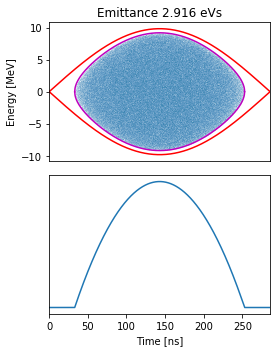

In [37]:
# Output figure

plt.figure('Beam', figsize=(4,5))
plt.clf()

plt.subplot(211)
plt.plot(beam.dt*1e9, beam.dE/1e6, '.',
         markersize=0.1, alpha=0.2)
plt.plot(time_bunch*1e9, dEbunch/1e6, 'm')
plt.plot(time_bunch*1e9, -dEbunch/1e6, 'm')
plt.plot(time_sep*1e9, dEsep/1e6, 'r')
plt.plot(time_sep*1e9, -dEsep/1e6, 'r')
plt.xlim((0, rf_station.t_rf[0,0]*1e9))
plt.gca().get_xaxis().set_visible(False)
plt.ylabel('Energy [MeV]')
plt.title('Emittance %.3f eVs'%(calc_area_bunch))

plt.subplot(212)
plt.plot(output_profile[0]*1e9, output_profile[1])
plt.xlim((0, rf_station.t_rf[0,0]*1e9))
plt.gca().get_yaxis().set_visible(False)
plt.xlabel('Time [ns]')

plt.tight_layout()
plt.savefig('figure_'+str(beam_label)+'.png')